# Assignment 3

*Part of the course:
Machine Learning (code: INFOB3ML), Fall 2024, Utrecht University*

Total points: 10 (100%)

Deadline: Friday 18 October, 23:59

**Write your names and student numbers here: Yoran de Jongh 5124476___**

Submit one ipynb file per pair.

**Before you submit, click Kernel > Restart & Run All to make sure you submit a working version of your code!**



## The BoAW Approach for emotion classification of utterances
In this programming assignment, you will be implementing Bag-of-Audio-Words (BoAW) method for acoustic low level descriptor (LLD) representation over utterances.
The acoustic LLDs per utterance are extracted and provided to you in separate files.
Your task is to implement the BoAW approach and the component methods, followed by classification using existing python libraries.

In a nutshell, you will be implementing the following functions (use of an existing library/package like `sklearn` is not allowed for this part):
1. Principal Component Analysis (PCA)
2. K-Means algorithm
3. BoAW representation function

You will then experiment with different combinations of PCA dimensions (`p_pca`) and K-Means components (`K`), and optimize said combinations using a Support Vector Machine (SVM) classifier.
You are given data of 16 speakers, where:
- The data of the first 8 speakers will be used as training set
- The data of speakers 9-12 will be used as validation set and
- The data of speakers 13-16 will be used as the test set.

The training set will be used to learn PCA and K-Means model, as well as to train the SVM classifiers using the BoAW representations as features and the emotions of the speakers as responses.
The hyper-parameter `C` of the classifiers as well as the number of principal components (`p_pca`) and cluster components (`K`) will be optimized on the validation set.
The top model (resulting from the best combination of `p_pca`, `K` and `C` hyper-parameters) will be applied to the test set.

### The BoAW approach
In the BoAW approach (see Figure 1 for an overview), we train a K-Means model using the combined LLDs from all trained set utterances.
Mainly because K-Means assumes no correlations in the data, and partly for reducing dimensionality, we first apply PCA to LLDs.
The BoAW representation amounts to assigning each LLD to the nearest K-Means cluster and computing a K-dimensional histogram of the accumulated instances around each mean.
This means that each utterance will be "represented" by a histogram, where each entry is the number of LLD sequences in the utterance that are assigned to a certain cluster.
Normalization of the histogram (so that each entry is a frequency as opposed to an absolute number) is possible.

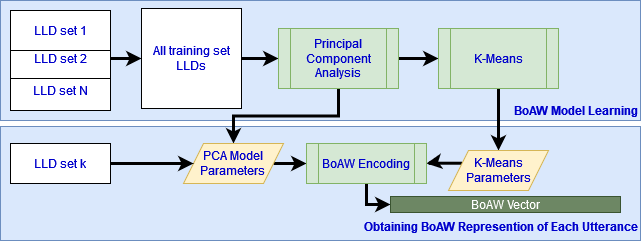

Figure 1: Bag-of-Audio-Words representation generation pipeline.

### Note
The last part of this assignment contains a lot of code that you do not need to (and should not) modify. However, it is important that you understand what is going on there, otherwise it will be difficult to fill-in the blanks when we ask you to.

The only places where you need to write code say "YOUR CODE HERE" explicitly.

### Required packages:
- numpy
- pandas
- scipy
- sklearn


### Required Dataset
You can download the zipped folder containing the extracted acoustic LLDs from subset of RAVDESS dataset from:

https://surfdrive.surf.nl/files/index.php/s/EeJxsea0CfCn17S

Unzip it in the same folder as this python notebook to ensure smooth working of the scripts we have prepared.

In [1]:
# If you work on Google Colab, uncomment following scripts to download and unzip the data file
!wget -c https://surfdrive.surf.nl/files/index.php/s/EeJxsea0CfCn17S/download
!unzip download

'wget' is not recognized as an internal or external command,
operable program or batch file.
'unzip' is not recognized as an internal or external command,
operable program or batch file.


### Step 1: Implementing PCA (Graded 20%)
Define a function `mypca(X)` with the following signature:
 - Input  `X`: N x D dimensional dataset
 - Output: `(W, lambda, mu)`
     + `W`: D x D eigenvalue sorted PCA projection matrix (i.e. first column is the first principal component)
     + `lambdas`: Dx1 vector of sorted eigenvalues (sorted in _descending_ order)
     + `mu`: Dx1 the mean of X (should be calculated and removed from the data before subsequent projection using W)
     
Hints:
 1. Recall that you should start by ensuring that the data has zero mean.
 2. You may want to make use of the numpy function `np.cov`. Be careful with what matrix you feed into this function. (Extra hint: look at the description `rowvar` argument of this function in the documentation).
 3. You will want to sort the eigenvalues in descending order, but numpy's sort method can only sort in ascending order. You may want to consider using `np.argsort` and using the fact that the ascending sorting indices for `-v` and the descending sorting indices for `v` are the same.
 4. Other numpy functions you may want to use: `np.mean`, `np.linalg.eig`.

In [2]:
import numpy as np
import scipy as sc



def mypca(X):
    mu = np.mean(X, axis = 0)
    X_zero_mean = X - mu
    
    sigma = np.cov(X_zero_mean, rowvar = False)
    eigenvals, eigenvecs = np.linalg.eig(sigma)
    
    lambdas = np.argsort(eigenvals)[::-1]
    
    W = eigenvecs[:, lambdas]
    return W, lambdas, mu

In [3]:
# TEST
np.random.seed(0)
X = np.random.rand(4, 3) # Three features; four samples.
W, lambdas, mu = mypca(X)
print(f"W = {W}")
print(f"\nlambdas = {lambdas}")
print(f"\nmu = {mu}")

assert W.shape == (3, 3), "Wrong shape of array W!"
assert len(lambdas) == 3, "Wrong length of vector lambdas!"
assert len(mu) == 3, "Wrong length of vector mu!"

W = [[-0.19056484  0.29124074  0.9374774 ]
 [ 0.75580654 -0.56588686  0.32943669]
 [ 0.62645153  0.7713306  -0.11228352]]

lambdas = [0 2 1]

mu = [0.47868135 0.70558555 0.68530379]


### Step 2: Implementing K-Means (Graded 40%)
Define a function `mykmeans(X, K, maxiter=200, epsilon=0.0001)` with the following signature:
 - Input
     + `X`: N x D dimensional dataset
     + `K`: Hyper-parameter (number of clusters) of K-Means
     + `maxiter`: maximum number of iterations (default 200)
     + `epsilon`: algorithm will stop when error improvement < epsilon (or number of iterations surpasses `maxiter`) (default 200)
 - Output: `(M, A)`
     + `M`: K x D dimensional matrix of means
     + `A`: N x 1 dimensional cluster assignments
     
Notes:
 1. It is not necessary but you may want to test your function in a simple example that is easy to visualize, like the ones in the book. In that case, you'll need to come up with it yourself. If you do so, I would advise doing so in a separate Python file and if you do it in this notebook _do not leave that extra code in, or you'll be penalized_.
 2. You will need to compute distances between samples `X[n]` and mean vectors `M[k]`. You can use the function `dist` given below for that. Do not modify it.

In [4]:
# DO NOT MODIFY
from scipy.spatial.distance import cdist
# Hint: you will need this function in your K-Means (mykmeans) and BoAW (myboaw) function implementations
def dist(X, M):
    """Computes the matrix with entries dist_matrix_nk = euclidean distance between X[n] and M[k] efficiently."""
    return cdist(X,M,metric='euclidean')

In [5]:
def mykmeans(X, K, maxiter=200, epsilon=0.0001):
    np.random.seed(1)
    N, D = X.shape
    # initialize model/output variables
    initial_indices = np.random.choice(N, K) # sample random K out of N instances to use as initial means
    M = X[initial_indices, :] # (K, D) matrix
    min_indices = np.zeros((N, 1))
    error_log = np.zeros((maxiter,1)) # You can save the errors here, to then use for computing delta
    iteration = 0
    cont = 1 # set to 0 when convergence criteria is met

    print("Running k-means...")
    while cont:
        dist_matrix = np.linalg.norm(X[:, np.newaxis] - M, axis = 2)  # maak de distant matrix, np.newaxis rechts voor column, axis = 2 voor collapsing naar N, K matrix
        min_indices = np.argmin(dist_matrix, axis = 1)  # index voor min afstand van elk punt
        M_old = M.copy()
        
        for k in range(K):# update the means
            if np.any(min_indices == k):
                M[k, :] = np.mean(X[min_indices == k], axis = 0)
                
        if iteration == 0:
            delta = 100000 # Something very high
        else:
            # Lets calculate the mean relative difference as delta
            delta = np.linalg.norm(M - M_old) / np.linalg.norm(M)   

        if (delta <= epsilon or iteration == maxiter):
            cont=0

        assert not np.isnan(delta), "delta is nan!"

        print(f"iteration: {iteration}, delta: {delta}")
        iteration = iteration + 1;

    # Final update of the indices specifying the clusters for each sample
    dist_matrix =  np.linalg.norm(X[:, np.newaxis] - M, axis = 2) #- -> recalculate the distance matrix with the updated means
    min_indices =  np.argmin(dist_matrix, axis = 1) # -> recalculate the cluster assignments using the up-to-date distance matrix
    A = min_indices # Just renaming

    return M, A

In [6]:
# TEST
np.random.seed(0)
X = np.random.randint(1, 10, (12, 2)) #  two features; 12 samples.
K = 3
mykmeans(X, K)

Running k-means...
iteration: 0, delta: 100000
iteration: 1, delta: 0.09345386270319955
iteration: 2, delta: 0.15891043154093207
iteration: 3, delta: 0.07235746052924216
iteration: 4, delta: 0.0


(array([[5, 8],
        [5, 2],
        [8, 3]]),
 array([1, 1, 2, 1, 0, 0, 2, 0, 0, 0, 2, 1], dtype=int64))

### Step 3: Implementing Bag of Audio Words (BoAW) representation (Graded 20%)
Define a function `myboaw(X_LLD, M)` which assigns the set of LLDs in the first argument to the nearest mean using the matrix of means given in the second argument.
The function should have the following signature:
 - Input:
     + `X_LLD`: N x D matrix of LLDs from each utterance, where N is the number of frames / instances and D is the (reduced) LLD dimensionality
     + `M`: K x D matrix of means (code vectors) outputed from K-Means
 - Output:
     + `boaw_rep`: K x 1 matrix with the _normalized_ boaw representation for each cluster k in each entry.
     
Hint:
 - After obtaining the K x 1 vector of unnormalized boaw representations (whose entries are integers), you can get the normalized version by simple dividing the unnormalized vector by the sum over all the entries of the unnormalized boaw vector.

In [ ]:
def myboaw(X_LLD, M):
    #--- YOUR CODE HERE ---#
    return boaw_rep

In [ ]:
# TEST
np.random.seed(0)
X = np.random.randint(1, 10, (12, 2)) #  two features; 12 samples.
K = 3
M, _ = mykmeans(X, K)
myboaw(X, M)

## Step 4: BoAW representation in action (graded 20%)

### Step 4.1: Data ingestion (0% - we do it for you!)
Read the data and place them in an appropriate data structure such that LLD sequence coming from each file (=utterance) is contained separately.

NOTES:
 1. Even though you do not need to write code for this part, make sure you understand what is going on, otherwise you will not comprehend the next steps.
 2. I would advise you to put the RAVDESS directory in the directory where this notebook is being run from - otherwise you will need to modify the variable `base_folder` below, as is written there.

In [ ]:
# DO NOT MODIFY

import glob
import os
import pandas as pd


# Each file will have some data and metadata we will want to record. We do so in using a class:
class FileData():
    def __init__(self, speakerid, emoid, LLDseq, LLDcount):
        self.speakerid = speakerid
        self.emoid = emoid
        self.LLDseq = LLDseq
        self.LLDcount = LLDcount


def ingest_ravdess_data(base_folder):
    """Build list of FileData instances, one per file/utterance."""
    LLD_folder = 'LLD_CSV_IS13/'
    list_actors_dirs = sorted(glob.glob(os.path.join(base_folder, LLD_folder, 'Actor*')))
    #print(list_actors_dirs)

    cnt = 0
    LLD_data = [] # To be populated by instances of FileData

    # The metadata can be obtained from the provided metadata.csv or from the
    # filename directly. We'll do the latter.

    for actor_folder in list_actors_dirs:
        list_actorLLDfiles = sorted(glob.glob(os.path.join(actor_folder, '*.csv')))
        #print(list_actorLLDfiles)
        for actor_file in list_actorLLDfiles:
            #print(f"file: {actor_file}")
            cnt = cnt + 1
            tmp_data_og = pd.read_csv(actor_file, sep=';')
            tmp_data = tmp_data_og.iloc[:, 2:]
            # if cnt == 1: # Visualise data on first iteration
            #     print(tmp_data.shape)
            #     print(tmp_data.iloc[:5, :4])
            #     cols = tmp_data.columns
            #     #print(f"Column names: {["\n\t" + f"{col}" for col in cols]}")
            #     print("\nColumns:")
            #     for col in cols:
            #         print("\t" + f"{col}")
            actor_file_wo_ext = os.path.splitext(actor_file)[0] # Remove extension from file name
            filecodes = str.split(actor_file_wo_ext,'-') # list with the filecodes, for example ['03', '02', ...]
            emoid = int(filecodes[2]) # the third filecode corresponds to the emotion id
            #print(f"emoid: {emoid}")
            speakerid = int(filecodes[-1]) # the last filecode corresponds to the actor/speaker id
            LLD_data.append(FileData(speakerid, emoid, tmp_data, tmp_data.shape[0]))
    assert len(LLD_data) == 704, "Something went wrong! There are 704 csv files in the RAVDESS dataset, but len(LLD_data) != 704."

    return LLD_data

In [ ]:
# ONLY MODIFY IF BASE-FOLDER IS DIFFERENT!
base_folder = './RAVDESS/' # Assuming that the RAVDESS directory is in the directory where this notebook is being run from.
LLD_data = ingest_ravdess_data(base_folder) # LLD_data is a data structure that keeps the acoustic LLD sequences for each audio file
# The goal of this assignment is to convert the (arbitrary length) LLD sequences into a fixed length utterance representation using Bag-of-Audio-Words approach

In [ ]:
# DO NOT MODIFY

# In this part, each function does one of these things:
#  1. Generate train data table with one LLDseq (corresponding to one audio frame) per row, using the first few speakers only.
#  2. Generate the mask arrays (using the speakerids) that will be used in the rest of this notebook
#        for splitting the datasets in train, val and test sets.
#  3. Generate the response variable vectors for the train, val and test sets.

def build_ravdess_train_dataset(LLD_data, n_speakers_train=8):
    """Builds RAVDESS dataset from list of FileData corresponding to the LLD of the utterances.

    Input:
        LLD_data -- list of FileData instances, one for each utterance file.

    Output:
        all_train_LLDsequences -- dataframe of shape (N_seqs=total number of LLD seqs, number of LLD features),
                                    with one LLD sequence per row.

    """
    all_train_LLDsequences = pd.concat([file_data.LLDseq for file_data in LLD_data if file_data.speakerid <= n_speakers_train]) # Each LLDseq is one feature vector

    return all_train_LLDsequences


def generate_splitting_masks(LLD_data, n_speakers_train=8, n_speakers_val=4):
    all_speakerids = np.array([file_data.speakerid for file_data in LLD_data])

    # Masks to build dataset using speaker ids:
    mask_train = all_speakerids <= n_speakers_train
    mask_val = np.logical_and(n_speakers_train < all_speakerids, all_speakerids <= n_speakers_train + n_speakers_val)
    mask_test = n_speakers_train + n_speakers_val < all_speakerids

    return mask_train, mask_val, mask_test, all_speakerids

def prepare_ravdess_response_data(LLD_data, mask_train, mask_val, mask_test):
    all_emoids = np.array([file_data.emoid for file_data in LLD_data])

    # Response's part of the dataset
    emoids_train = all_emoids[mask_train]
    emoids_val = all_emoids[mask_val]
    emoids_test = all_emoids[mask_test]

    return emoids_train, emoids_val, emoids_test

In [ ]:
# DO NOT MODIFY
# Make 0.5-0.25-0.25 train-val-test split using speakerid
# (i.e. 8 speakers for the train, 4 speakers for the val and 4 speakers for the test sets).
mask_train, mask_val, mask_test, _ = generate_splitting_masks(LLD_data)
emoids_train, emoids_val, emoids_test = prepare_ravdess_response_data(LLD_data, mask_train, mask_val, mask_test)
LLDs_train = build_ravdess_train_dataset(LLD_data)

In [ ]:
# TEST:
print(LLDs_train.shape)
print(emoids_train[:44]) # Look at some responses

assert LLDs_train.shape[1] == 130, "There should be 130 features."

### Step 4.2: Learn PCA projection (5%)
Learn a PCA projection (i.e. the eigenvectors and eigenvalues of the covariance matrix) using your own PCA implementation, namely `mypca`.

NOTE:
If there is a large variance across variances of the features then it is wise to z-normalize the data before applying PCA (using for example an instance of the `sklearn.preprocessing.StandardScaler` class).

Running the code below shows that indeed there is a huge difference in variances

In [ ]:
# DO NOT MODIFY
data_var = LLDs_train.var()
print(f"Variances:\n{'-'*5}\n{data_var}\n{'-'*5}")
#ratio_extremes = np.max(data_var)/np.min(data_var)
var_of_variances = np.var(data_var)
#print(ratio_extremes)
print(f"Variance of the variances: {var_of_variances}")

In [ ]:
# You now need to Z-normalize LLDs_train. Call the resulting variable X_zn.
# You can use sklearn.preprocessing.StandardScaler.
from sklearn.preprocessing import StandardScaler
# Instantiate scaler

scaler = StandardScaler()
#--- YOUR CODE HERE ---#
# Fit scaler

# Finally, apply mypca to extract pca_W and pca_lambdas
pca_W, pca_lambdas, _ = mypca(X_zn)

In [ ]:
# TEST:
print(X_zn.shape)
print(pca_W.shape)
print(pca_lambdas.shape)

assert X_zn.shape == (162621, 130), "Something went wrong!"
assert pca_W.shape == (130, 130), "Something went wrong!"
assert pca_lambdas.shape == (130,), "Something went wrong!"

### Step 4.3: Applying PCA and K-means (5%)

Project the training set using the first `p_pca` PCA components and train a K-Means model with K components.
Using a number `p_pca` of principal components equal to 120 and a number of clusters `K` of 256.

In [ ]:
# DO NOT MODIFY
p_pca = 120
K = 256

We already have the pre-processed (z-normalized) training LLD data.

First, get PCA projection onto the (basis spanned by) the first p_pca eigenvectors.
Call the resulting matrix `Z_LLD_train`.

Hint: This function should not have more than a couple lines.

In [ ]:
def project_onto_pcs(X, pca_W, p_pca):
    # Projecting coincides with matrix multiplication (if pca_W column vectors are normalized, which they are):
    #--- YOUR CODE HERE ---#
    return X_projected

In [ ]:
# DO NOT MODIFY
Z_LLD_train = project_onto_pcs(X_zn, pca_W, p_pca)

In [ ]:
# TEST
print(Z_LLD_train.shape)
assert Z_LLD_train.shape == (162621, 120), "Something went wrong! Shape of Z_LLD_train is incorrect!"

In [ ]:
# DO NOT MODIFY
# We will use only every fourth frame/LLD sequence, to reduce the computation time.

def subsample(X, n_subsample):
    X_subsample = X[np.arange(X.shape[0], step=n_subsample), :] # Use every n_sample'th point
    return X_subsample

n_subsample = 4 # Use every fourth frame
Z_LLD_train_subsample = subsample(Z_LLD_train, n_subsample)
print(Z_LLD_train_subsample.shape)

In [ ]:
# Apply your kmeans implementation to the projected, subsampled, train data:
np.random.seed(0)
M, _ = #--- YOUR CODE HERE ---#

### Step 4.4: BoAW encode each file using the loaded data (5%)
Using the result of the K-means method and LLD_data, use your implementation of BoAW to build one histogram per utterance/file.

In [ ]:
# We can collect all boaw representations in one matrix. We will later split it!

def boaw_representations(LLD_data, scaler, pca_W, p_pca, K, M):
    "Generate matrix with one boaw representation (for each utterance) per row."
    N_files = len(LLD_data) # One sample per file/utterance, each sample being a histogram.
    #print(f"Number of utterances: {N_files}")
    X_boaw_all = np.zeros((N_files, K)) # Each row will have K entries, each with the frequency of one of the clusters in that utterance/audio file.

    for i in range(N_files):
        #--- YOUR CODE HERE ---#

    return X_boaw_all

In [ ]:
# DO NOT MODIFY
X_boaw_all = boaw_representations(LLD_data, scaler, pca_W, p_pca, K, M)
print(f"X_boaw_all shape: {X_boaw_all.shape}")
assert X_boaw_all.shape == (704, 256), "Something went wrong!"

In [ ]:
# DO NOT MODIFY
# And now we split the representations in train and val sets

def split_ravdess_filewise_boaw(X_boaw_all, mask_train, mask_val, mask_test):
    """Use the masks computed before to split X_boaw_all in train, val and test parts."""
    X_boaw_train = X_boaw_all[mask_train]
    X_boaw_val = X_boaw_all[mask_val]
    X_boaw_test = X_boaw_all[mask_test]

    return X_boaw_train, X_boaw_val, X_boaw_test

In [ ]:
# DO NOT MODIFY
X_boaw_train, X_boaw_val, X_boaw_test = split_ravdess_filewise_boaw(
    X_boaw_all, mask_train, mask_val, mask_test
)
Y_train = emoids_train
Y_val = emoids_val
Y_test = emoids_test

In [ ]:
# TEST
print(X_boaw_train.shape)
print(X_boaw_val.shape)
print(X_boaw_test.shape)
print(Y_train.shape)
print(Y_val.shape)
print(Y_test.shape)

### Step 4.5: (5%)
Use the sklearn implementation of LinearSVC (linear support vector machine) to optimize C using the validation set.

To optimize C, simply try C = 10^-6, 10^-5, 10^-4, 10^-3, 10^-2, 10^-1, 10^-0, and select the one giving the best accuracy.
Make sure to output best performance (i.e. accuracy) and corresponding C per BoAW representation.

In [ ]:
from sklearn.svm import LinearSVC

C_set = 10.**np.arange(-6, 1) # the experimental set of SVM complexity values

def generate_performances(X_train, X_val, Y_train, Y_val, C_set):
    """Compute the performances of linear svc (with random state = 1) for each C in C_set.

    Output:
        performances -- (len(C_set), 1) array with accuracy corresponding to C_set[i] on entry i.

    """
    performances = np.zeros((len(C_set), 1)) # Performace for a certain C will simply be average correct preds = accuracy
    for i in range(len(C_set)):
        #--- YOUR CODE HERE ---#

    return performances

def find_best_C(C_set, performances):
    """Determines the best C in C_set using the list performances of accuracies.

    Output:
        best_C_boaw -- float
        best_accuracy_boaw -- float
    """
    #--- YOUR CODE HERE ---#

    return best_C_boaw, best_accuracy_boaw

In [ ]:
# DO NOT MODIFY
performances = generate_performances(X_boaw_train, X_boaw_val, Y_train, Y_val, C_set)
best_C_boaw, best_accuracy_boaw = find_best_C(C_set, performances)

print(f"For K={K} and p_pca={p_pca}:")
print(f"\tBest accuracy: {best_accuracy_boaw}")
print(f"\tBest C: {best_C_boaw}")

### Step 4.5: Repeat steps 4.3 and 4.4 with different values of `p_pca` and `K` (0% - we do it for you!)

Use `p_pca` in {120, 130}.
Use `K` in {256, 512}.
(Therefore you'll have 4 BoAW representations in total).

Important note: since there will be hundreds of thousands of LLD vectors
it will be wise to subsample them before K-Means taking one every `n_subsample=4` frames.

In [ ]:
# DO NOT MODIFY
def generate_boaw_representation(X_zn, p_pca, pca_W, K, n_subsample, scaler):
    X_projected = project_onto_pcs(X_zn, pca_W, p_pca)
    X_projected_subsample = subsample(X_projected, n_subsample)
    M, _ = mykmeans(X_projected_subsample, K)
    X_boaw_all = boaw_representations(LLD_data, scaler, pca_W, p_pca, K, M)
    #print(X_boaw_all.shape)
    return X_boaw_all

def test_hyperparameters(
    X_zn, Y_train, Y_val, p_pcas, pca_W, Ks, n_subsample, scaler, C_set
):
    X_boaw_all_dict = {}
    for p_pca in p_pcas:
        for K in Ks:
            print("-"*5 + f"\np_pca: {p_pca}, K: {K}")

            # Generate the representation
            X_boaw_all = generate_boaw_representation(
                X_zn, p_pca, pca_W, K, n_subsample, scaler
            )

            # Split boaw data
            X_boaw_train, X_boaw_val, X_boaw_test = split_ravdess_filewise_boaw(
                X_boaw_all, mask_train, mask_val, mask_test
            )

            # One list of performances per representation
            performances = generate_performances(
                X_boaw_train, X_boaw_val, Y_train, Y_val, C_set
            )

            # One best C and best accuracy per representation
            best_C_boaw, best_accuracy_boaw = find_best_C(C_set, performances)

            print(f"\nFor K={K} and p_pca={p_pca}:")
            print(f"\tBest accuracy: {float(best_accuracy_boaw)}")
            print(f"\tBest C: {best_C_boaw}")

            X_boaw_all_dict[(p_pca, K)] = X_boaw_all

    return X_boaw_all_dict

In [ ]:
# DO NOT MODIFY
n_subsample = 4
p_pcas = [120, 130]
Ks = [256, 512]
X_boaw_all_dict = test_hyperparameters(
    X_zn, Y_train, Y_val, p_pcas, pca_W, Ks, n_subsample, scaler, C_set
)

### Step 4.6: (0% - we do it for you!)
 We did everything using the train and validation sets only until now. This enables us to choose the best hyperparameters `p_pca`, `K` and `C`.

 Looking at the performance/accuracy results you obtained in the previous step, answer the question: which `p_pca`, `K` and `C` combination gave the best validation set performance?
 AND: using the boaw encoding for that `p_pca, K` combination and the best C, finally apply the setting on the test set.

In [ ]:
# NOT GRADED, BUT YOU CAN PLAY WITH THE VALUES OF K, p_pca AND C
# Best values:
K = 512
p_pca = 130
C = 10.**-6

# 1. Now we combine the training and validation, retrain a model with best C and
# best boaw representation (i.e. best K, p_pca) then predict on the test set.

# Generate boaw representation for this p_pca and K:
X_boaw_all = X_boaw_all_dict[(p_pca, K)]

# Split boaw data
X_boaw_train, X_boaw_val, X_boaw_test = split_ravdess_filewise_boaw(
    X_boaw_all, mask_train, mask_val, mask_test
)


# join train and val in one
X_boaw_trainval = np.concatenate([X_boaw_train, X_boaw_val])
Y_trainval = np.concatenate([Y_train, Y_val])

# 2. Now we run the classification model
clf = LinearSVC(C=C, random_state=1)
clf.fit(X_boaw_trainval, Y_trainval)
preds_test = clf.predict(X_boaw_test)
performance = np.mean(Y_test == preds_test)

print(f"\nFor K={K}, p_pca={p_pca} and C={C}:")
print(f"\tAccuracy: {performance}.")

Note: If everything went well, you should have an accuracy around 0.43 (on the test set) when using the best hyper-parameters `K`, `p_pca` and `C`.

**Before you submit, click Kernel > Restart & Run All to make sure you submit a working version of your code!**

--- End of the assignment ---